# Fitting various models to the data

In [16]:
import numpy as np
import pymc as pm
import scipy.stats as stats

import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import bokeh.io
import bokeh.mpl
import bokeh.plotting
bokeh.io.output_notebook()

from IPython.core.pylabtools import figsize
from IPython import display
from getProcessed import getProcessed

titrD2 = getProcessed('titrationD2')
titrD4 = getProcessed('titrationD4')
timecourse = getProcessed('finalRun')



Loading BokehJS ...

# First, we try an out of the box Gaussian mixture model

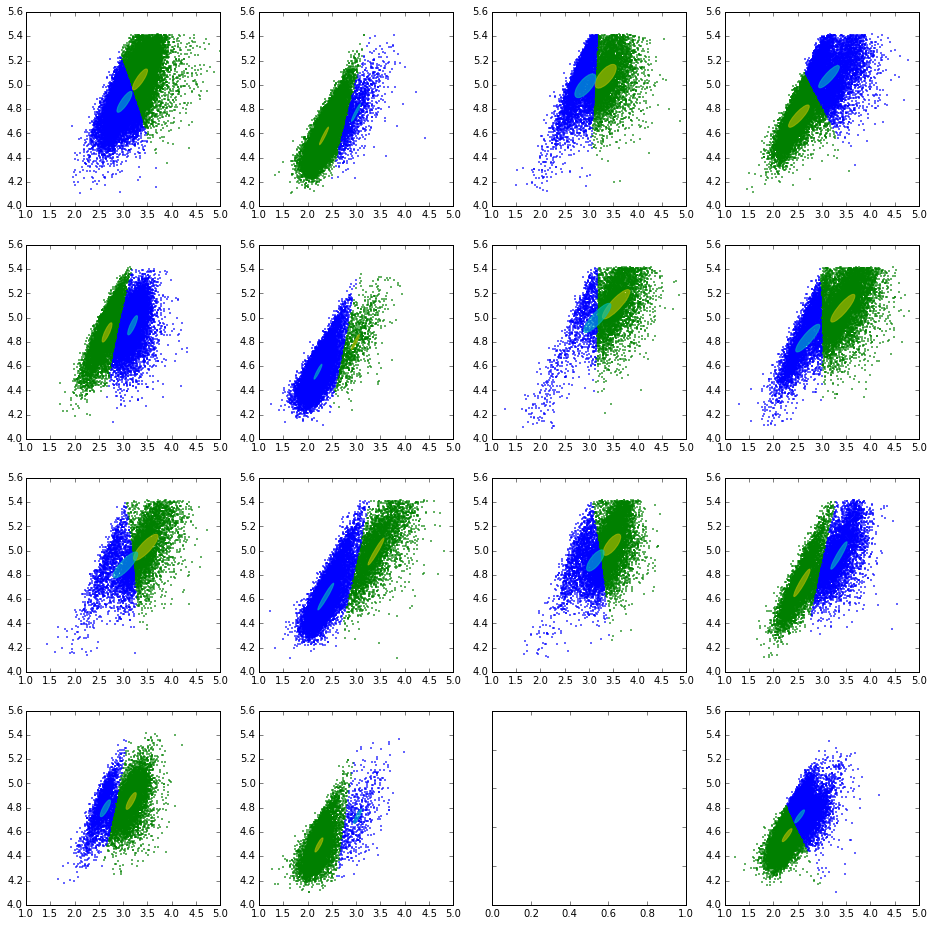

In [47]:
from sklearn import mixture
covariance_type='tied'

from fitGMMModel import plotModel
figsize(16, 16)

#Try using a Gaussian mixture model
models = [ mixture.GMM( n_components=2, covariance_type=covariance_type, n_iter=800, n_init=20) for entry in timecourse.gated]
toFit = [ np.log10(entry.data[['M Cherry-A', 'SSC-A']]).dropna().as_matrix() for entry in timecourse.gated ]


plt.subplots(4, 4, sharex='col', sharey='row')

for index in range(len( timecourse.gated)):
    models[index].fit( toFit[index] )

    plotModel( models[index], toFit[index], plotnum=index, covariance_type=covariance_type)
    plt.autoscale(tight=True)
    plt.xlim([1,5])
    plt.ylim([4, 5.6])
    #print index
    

plt.show()

The out of the box solver usually does ok in capturing the behaviors that we can see by eye. However, it would be nice to have better control over the covariance matrices that we are fitting. In order to do this, I tried a more curated approach to the problem.

# MCMC approach
We can make use of some of our previous controls to fit the correlation matrices for the clustering

In [17]:
import pymc as pm
import scipy.stats as stats

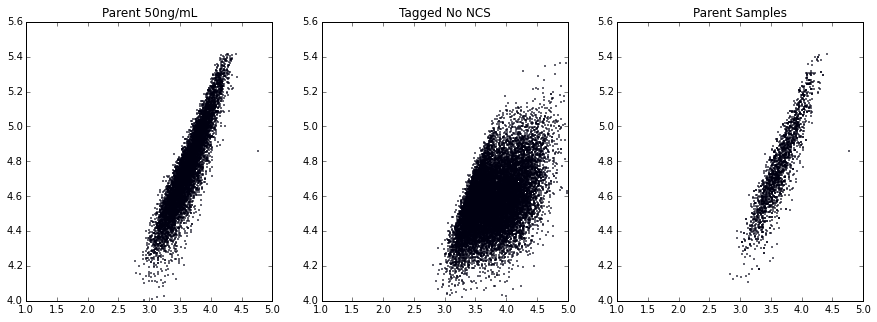

In [18]:
noTag = np.log10( titrD4.gated[2].data[['M Cherry-A', 'SSC-A']]).dropna().as_matrix()
negTag = np.log10( titrD4.gated[-1].data[['M Cherry-A', 'SSC-A']]).dropna().as_matrix()

# take a set of samples to train on from the parental dataset.
ind = np.random.choice(range(noTag.shape[0]), size=(2000,1))
noTagSamples = noTag[ind,:].squeeze()

figsize(15,5)
plt.subplot(1,3,1)
plt.scatter(noTag[:,0], noTag[:,1], 0.5);
plt.xlim([1,5])
plt.ylim([4, 5.6]);
plt.title('Parent 50ng/mL');

plt.subplot(1,3,2)
plt.scatter(negTag[:,0], negTag[:,1], 0.5);
plt.xlim([1,5])
plt.ylim([4, 5.6]);
plt.title( 'Tagged No NCS');

plt.subplot(1,3,3)
plt.scatter(noTagSamples[:,0], noTagSamples[:,1], 0.5);
plt.xlim([1,5])
plt.ylim([4, 5.6]);
plt.title('Parent Samples');




The plot was shifted because of the difference in PMT gain in the mCh channel. Fit a multivariate Gaussian to find the cross-correlation structure 

-2063.62135703


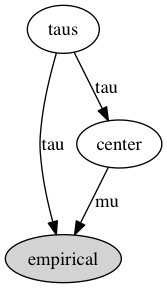

In [170]:
# the model

#priors
# Wishart prior
tauGuess = np.eye(2)
taus = pm.Wishart('taus', 2, tauGuess )

centerGuess = np.array([3.7, 4.7])
center = pm.MvNormal('center', centerGuess, taus)

#distribuion
empirical = pm.MvNormal('empirical', center, taus, value=noTagSamples, observed=True)

model = pm.Model([empirical, taus, center])

graph = pm.graph.dag( model)
display.Image(graph.create_png())

In [22]:
mcmc = pm.MCMC(model)

nSamp = 12000
burn=2000
times = np.array( range(nSamp-burn) )
samples = mcmc.sample(nSamp, burn)

 [-----------------100%-----------------] 12000 of 12000 complete in 169.2 sec

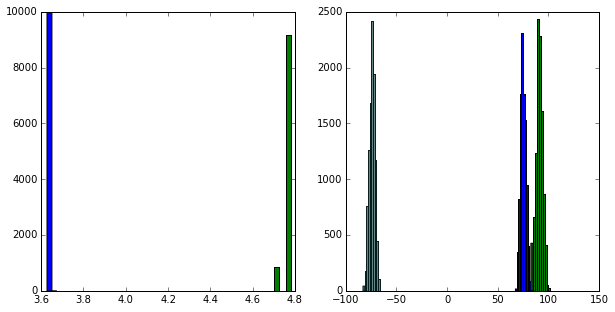

In [23]:
figsize(10,5);


cenTrace = mcmc.trace('center')
plt.subplot(1,2,1)
plt.hist( cenTrace[:], bins=20 );

tauTrace = mcmc.trace('taus')
plt.subplot(1,2,2)
plt.hist(tauTrace[:,0,0], bins=10);
plt.hist(tauTrace[:,1,1], bins=10);
plt.hist(tauTrace[:,0,1], bins=10, color='r', alpha=0.8);
plt.hist(tauTrace[:,1,0], bins=10, color='c', alpha=0.6);



Examining the prior distributions and the evolution of the distributions over time shows the sureness of the fit and whether the burn time was sufficient

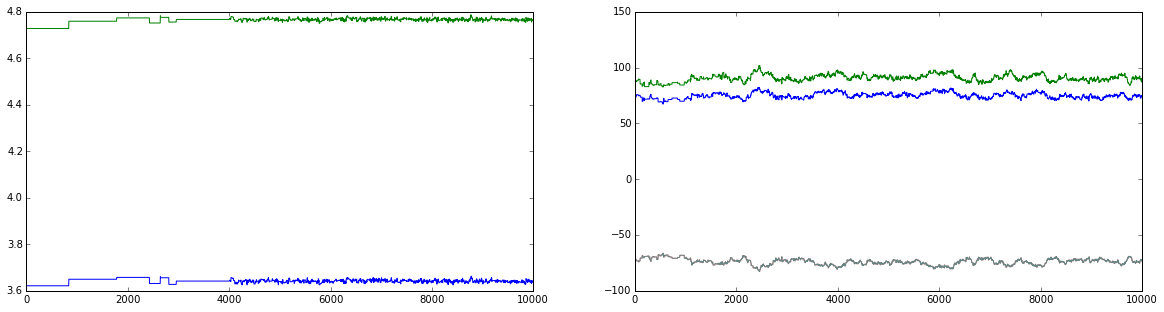

In [24]:
figsize(20,5);
plt.subplot(1,2,1)
plt.plot( times, cenTrace[:,0])
plt.plot( times, cenTrace[:,1])


plt.subplot(1,2,2)
plt.plot( times, tauTrace[:,0,0])
plt.plot( times, tauTrace[:,1,1])
plt.plot( times, tauTrace[:,0,1], color='r', alpha=0.8)
plt.plot( times, tauTrace[:,1,0], color='c', alpha=0.6)


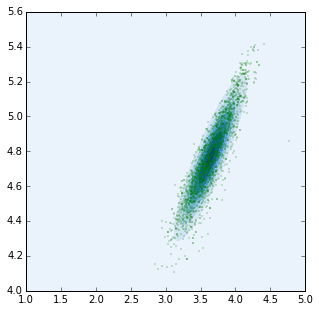

In [29]:
#Approximate by the posterior mean. This is itself an approximation to the MAP distribution
center_post_mean = cenTrace[:].mean(axis=0)
tau_post_mean = tauTrace[:].mean(axis=0)

cov_post_mean = np.linalg.inv(tau_post_mean)

#generate the plot
xs = np.linspace(1, 5, 200)
ys = np.linspace(4, 5.6, 200)

X, Y = np.meshgrid(xs, ys)
position = np.dstack((X, Y))

full_posterior = stats.multivariate_normal(center_post_mean, cov_post_mean)

figsize(5,5)
plt.contourf( X, Y, full_posterior.pdf(position), cmap="Blues")
plt.scatter(noTagSamples[:,0], noTagSamples[:,1], 0.3, color='g', alpha=0.4);
plt.xlim([1,5])
plt.ylim([4, 5.6]);

### Beautiful.
Does expressing everything in terms of the eigenvectors of this covariance help anything? Alternatively, can we just tdo the fits with fixed covarance?

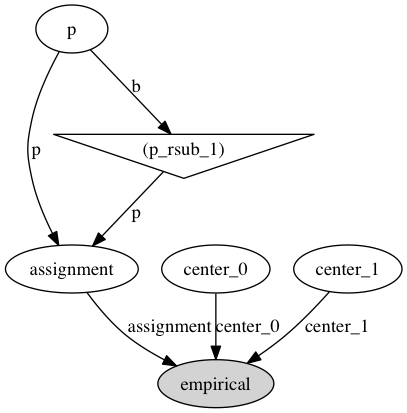

In [211]:
# New mixture model for fitting the experimental data.
# Once again, the GMM doesn't work because there is no control over the structure of the covariance matrix

def makeModel(data):
    # Assignment to a cloud
    p = pm.Uniform("p", 0, 1) #prior

    assignment = pm.Categorical("assignment", [p, 1 - p], size=data.shape[0])

    # prefit covariance
    fitCov = cov_post_mean
    #mean prior
    center_0 = pm.MvNormal('center_0', np.array([2.5, 5]), fitCov )
    center_1 = pm.MvNormal('center_1', np.array([3, 5]), fitCov ) 


    # while the most one dimensional distributions are comfortable generating multiple samples,
    # the MvNormal is not. As a result, we must make a multi-MvNormal variable
    @pm.stochastic(observed=True)
    def empirical(value=data, center_0=center_0, center_1=center_1, tau=fitCov, assignment=assignment):
        # assume that the data is IID.
        running = 0
        # do each of the the subpopulations independently
        pop_0 = data[assignment == 0]
        pop_1 = data[assignment == 1]

        prob_0 = pm.mv_normal_like(pop_0, center_0, tau)
        prob_1 = pm.mv_normal_like(pop_0, center_1, tau)
        return prob_0 + prob_1

    expModel = pm.Model( [p, assignment, fitCov, center_0, center_1, empirical])
    return expModel


# an old solution
#@pm.deterministic
#def centers( assignment=assignment, center_0=center_0, center_1=center_1):
#    out = np.zeros(( len(data),  2) ) #initialize output
#    out[ assignment == 0, :] = center_0 
#    out[ assignment == 1,:] = center_1
#    return out


graph = pm.graph.dag( model)
display.Image(graph.create_png())

In [213]:
expMcmc = pm.MCMC(makeModel(toFit[3]))

nSamp = 1500
burn=0
times = np.array( range(nSamp-burn) )
samples = expMcmc.sample(nSamp, burn)

 [-----------------100%-----------------] 1500 of 1500 complete in 32.5 sec

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


In [217]:
cenTrace = mcmc.trace('center_0')
#plt.subplot(1,2,1)
#plt.hist( cenTrace[:], bins=20 );


In [218]:
cenTrace[:]

array([], shape=(0, 2), dtype=float64)

In [220]:
mcmc.trace('p')[:]

array([], dtype=float64)

In [144]:
# assignment to the clusters. We initialize with a uniform prior
p = pm.Uniform('p', 0, 1)
assignment = pm.Categorical("assignment", [p, 1 - p], size=data.shape[0])




In [145]:
type(timecourse)
dir(timecourse)
timecourse.gated

[<FCMeasurement 'd0_neg_001.fcs'>,
 <FCMeasurement 'd2_+_002.fcs'>,
 <FCMeasurement 'd2_neg_001.fcs'>,
 <FCMeasurement 'd4_++_004.fcs'>,
 <FCMeasurement 'd4_+-_003.fcs'>,
 <FCMeasurement 'd4_-+_002.fcs'>,
 <FCMeasurement 'd4_--_001.fcs'>,
 <FCMeasurement 'd6_+++_008.fcs'>,
 <FCMeasurement 'd6_++-_004.fcs'>,
 <FCMeasurement 'd6_+-+_006.fcs'>,
 <FCMeasurement 'd6_+--_003.fcs'>,
 <FCMeasurement 'd6_-++_007.fcs'>,
 <FCMeasurement 'd6_-+-_002.fcs'>,
 <FCMeasurement 'd6_--+_005.fcs'>,
 <FCMeasurement 'd6_---_001.fcs'>]

In [146]:
.2*np.ones((2,2))

array([[ 0.2,  0.2],
       [ 0.2,  0.2]])

In [147]:
np.max( noTag )

5.4168468